In [1]:
!pip install semanticscholar python-dotenv requests -q

import json
import os
from semanticscholar import SemanticScholar
from dotenv import load_dotenv


In [2]:

# PDF-ONLY RESULTS (SemanticScholar-Compatible Output)

!pip install requests feedparser -q

import requests
import feedparser
import json
from datetime import datetime
import os


def clean(x):
    return x.replace("\n", " ").strip() if isinstance(x, str) else x


# ====================================================
# 1. Europe PMC → only keep papers with PDF
# ====================================================

def search_europe_pmc(query, limit=20):
    print("\n🔍 Searching Europe PMC...")

    url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/search?query={query}&format=json&pageSize={limit}"
    try:
        data = requests.get(url, timeout=10).json()
        results = data.get("resultList", {}).get("result", [])
    except:
        return []

    papers = []

    for p in results:
        pdf_url = None

        # FIXED: Improved PDF detection
        # Check open access status first
        if p.get("isOpenAccess") == "Y":
            # Try PMC ID based URL
            pmcid = p.get("pmcid")
            if pmcid:
                pdf_url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmcid}/pdf/"

            # If no PMC ID, check fullTextUrlList
            if not pdf_url and "fullTextUrlList" in p:
                urls = p["fullTextUrlList"].get("fullTextUrl", [])
                for u in urls:
                    doc_style = u.get("documentStyle", "").lower()
                    site = u.get("site", "").lower()
                    availability = u.get("availability", "")

                    # Look for PDF specifically
                    if "pdf" in doc_style or "pdf" in site:
                        pdf_url = u.get("url")
                        break
                    # Or free full text
                    elif availability == "Free" and u.get("url"):
                        potential_url = u.get("url")
                        if potential_url and "pdf" in potential_url.lower():
                            pdf_url = potential_url
                            break

        # 🚫 Skip papers without PDFs (FIXED)
        if not pdf_url:
            continue
        papers.append({
            "title": clean(p.get("title", "")),
            "authors": [a.get("fullName", "") for a in p.get("authorList", {}).get("author", [])],
            "year": int(p["pubYear"]) if p.get("pubYear") else None,
            "paperId": p.get("id", ""),
            "abstract": clean(p.get("abstractText", "")),
            "citationCount": p.get("citedByCount", 0),
            "venue": p.get("journalTitle", ""),
            "url": p.get("pubmedUrl", ""),
            "pdf_url": pdf_url,
            "has_pdf": True,
            "source": "Europe PMC"
        })

    print(f"➡ Europe PMC PDF results: {len(papers)}")
    return papers


# ====================================================
# 2. arXiv → ALL papers have PDF
# ====================================================
def search_arxiv(query, limit=20):
    print("\n🔍 Searching arXiv...")

    url = f"http://export.arxiv.org/api/query?search_query=all:{query}&start=0&max_results={limit}"
    try:
        feed = feedparser.parse(url)
    except:
        return []

    papers = []

    for entry in feed.entries:
        pdf_url = entry.id.replace("abs", "pdf") + ".pdf"

        papers.append({
            "title": clean(entry.title),
            "authors": [a.name for a in entry.authors],
            "year": int(entry.published[:4]),
            "paperId": entry.id,
            "abstract": clean(entry.summary),
            "citationCount": 0,
            "venue": "arXiv",
            "url": entry.link,
            "pdf_url": pdf_url,
            "has_pdf": True,
            "source": "arXiv"
        })

    print(f"➡ arXiv PDF results: {len(papers)}")
    return papers


# ====================================================
# 3. Combine + PDF Only
# ====================================================
def search_papers(query, limit=20):
    print(f"\n🔎 Searching for: {query}")

    pmc_papers = search_europe_pmc(query, limit)
    arxiv_papers = search_arxiv(query, limit)

    all_papers = pmc_papers + arxiv_papers

    print(f"\n📊 TOTAL PDF papers found: {len(all_papers)}")
    return all_papers


# ====================================================
# SAVE RESULTS
# ====================================================
def save_search_results(papers, topic):
    os.makedirs("data/search_results", exist_ok=True)

    safe_topic = "".join(c for c in topic if c.isalnum() or c == " ").replace(" ", "_")
    filename = f"paper_search_results_{safe_topic}.json"

    path = f"data/search_results/{filename}"

    with open(path, "w", encoding="utf-8") as f:
        json.dump({
            "topic": topic,
            "timestamp": datetime.now().isoformat(),
            "papers": papers
        }, f, indent=4)

    print(f"\n💾 Saved results → {path}")
    return path


# ====================================================
# DISPLAY RESULTS (PDF ONLY)
# ====================================================
def display_results(papers, limit=10):
    print("\n=========== PDF AVAILABLE PAPERS ===========\n")
    for i, p in enumerate(papers[:limit], 1):
        print(f"{i}. {p['title']}")
        print(f"   Authors: {', '.join(p['authors'][:4])}")
        print(f"   Year: {p['year']}  | Source: {p['source']}")
        print(f"   PDF: {p['pdf_url']}\n")


# ====================================================
# MAIN FUNCTION
# ====================================================
def main_search():
    query = input("Enter research topic: ").strip()

    papers = search_papers(query, limit=20)
    display_results(papers)
    save_search_results(papers, query)

    print("\n🎉 MODULE 1 COMPLETE — PDF-ONLY MODE ENABLED ✔")
    return papers


# Run module
if __name__ == "__main__":
    main_search()
def main_search():
    query = input("Enter research topic: ").strip()

    papers = search_papers(query, limit=20)

    # ADDED: Check for empty results
    if not papers:
        print("\n❌ No papers with PDFs found. Try a different search query.")
        return []

    display_results(papers)
    save_search_results(papers, query)

    print("\n🎉 MODULE 1 COMPLETE – PDF-ONLY MODE ENABLED ✓")
    return papers


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 2.3 MB/s eta 0:00:00
Enter research topic: parkinson

🔎 Searching for: parkinson

🔍 Searching Europe PMC...
➡ Europe PMC PDF results: 1

🔍 Searching arXiv...
➡ arXiv PDF results: 20

📊 TOTAL PDF papers found: 21

=========== PDF AVAILABLE PAPERS ===========

1. Stigmatization and bias in interpreting lichen sclerosus risk factors.
   Authors: 
   Year: 2025  | Source: Europe PMC
   PDF: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC12685388/pdf/

2. Deep 1D-Convnet for accurate Parkinson disease detection and severity prediction from gait
   Authors: Imanne El Maachi, Guillaume-Alexandre Bilodeau, Wassim Bouachir
   Year: 2019  | Source: arXiv
   PDF: http://arxiv.org/pdf/1910.11509v4.pdf

3. A Three-groups Non-local Model for Combining Heterogeneous Data Sources to Identify Genes Associated with Parkinson's Disease
   Authors: Troy P. Wixson, Benjamin A. Shaby, Daisy L. Philtron, Internati

In [6]:
# ============================================
# MODULE 2: PDF Download + DOC Generation
# Compatible with Updated Module 1 (PDF-only)
# ============================================
!pip install requests python-docx PyMuPDF -q

import json
import os
import requests
import fitz  # PyMuPDF
from datetime import datetime
from docx import Document
from pathlib import Path
from IPython.display import FileLink, display
from google.colab import files


# ====================================================
# LOAD SEARCH RESULTS
# ====================================================

def load_search_results(filepath=None):
    base = "data/search_results"
    if not filepath:
        files_list = sorted(
            [f for f in os.listdir(base) if f.endswith(".json")],
            key=lambda x: os.path.getmtime(os.path.join(base, x)),
            reverse=True
        )
        if not files_list:
            print("❌ No search results found. Run Module 1 first.")
            return None
        filepath = os.path.join(base, files_list[0])

    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)

    print(f"📄 Loaded {len(data['papers'])} papers (PDF-only)")
    return data



# ====================================================
# FILTERING & SELECTION
# ====================================================
def select_top_papers(papers, count=3):
    """Allow user to select papers interactively"""

    # Display available papers
    print("\n" + "="*70)
    print("AVAILABLE PAPERS FOR DOWNLOAD")
    print("="*70)

    for i, p in enumerate(papers, 1):
        print(f"\n[{i}] {p['title'][:75]}...")
        print(f"    Authors: {', '.join(p['authors'][:3])}")
        print(f"    Year: {p.get('year', 'N/A')} | Source: {p['source']}")

    print("\n" + "="*70)
    print(f"Select papers to download (max {count})")
    print("Examples: '1,3,5' or '1-3' or 'all' or 'top' (for top papers)")
    print("="*70)

    while True:
        choice = input("\nYour selection: ").strip().lower()

        # Option 1: Download all (up to limit)
        if choice == 'all':
            selected = papers[:min(len(papers), count)]
            break

        # Option 2: Top papers (sorted by citations)
        elif choice == 'top':
            sorted_papers = sorted(
                papers,
                key=lambda x: (x.get("year") or 0),
                reverse=True
            )
            selected = sorted_papers[:count]
            break

        # Option 3: Range (e.g., 1-3)
        elif '-' in choice:
            try:
                start, end = map(int, choice.split('-'))
                if 1 <= start <= end <= len(papers):
                    selected = papers[start-1:min(end, start-1+count)]
                    break
                else:
                    print(f"❌ Invalid range. Use numbers between 1-{len(papers)}")
            except:
                print("❌ Invalid format. Use: 1-3")
                continue

        # Option 4: Comma-separated (e.g., 1,3,5)
        else:
            try:
                indices = [int(x.strip()) for x in choice.split(',')]
                if all(1 <= i <= len(papers) for i in indices):
                    if len(indices) > count:
                        print(f"⚠️ Too many papers. Limiting to first {count}")
                        indices = indices[:count]
                    selected = [papers[i-1] for i in indices]
                    break
                else:
                    print(f"❌ Numbers must be between 1-{len(papers)}")
            except:
                print("❌ Invalid format. Use: 1,2,3")
                continue

    print(f"\n✓ Selected {len(selected)} paper(s) for download:")
    for i, p in enumerate(selected, 1):
        print(f"  {i}. {p['title'][:70]}...")

    return selected



# ====================================================
# DOC CREATION
# ====================================================

def create_doc(paper, filepath):
    doc = Document()
    doc.add_heading(paper["title"], level=1)

    doc.add_paragraph(f"Authors: {', '.join(paper.get('authors', []))}")
    doc.add_paragraph(f"Year: {paper.get('year')}")
    doc.add_paragraph(f"Venue: {paper.get('venue')}")
    doc.add_paragraph(f"Source: {paper.get('source')}")

    doc.add_heading("Abstract", level=2)
    doc.add_paragraph(paper.get("abstract") or "No abstract available")

    doc.add_heading("PDF Link", level=2)
    doc.add_paragraph(paper.get("pdf_url") or "Not Available")

    doc.save(filepath)
    return filepath



# ====================================================
# PDF DOWNLOADER (FIXED)
# ====================================================

def verify_pdf(path):
    try:
        if os.path.getsize(path) < 5000:
            return False
        doc = fitz.open(path)
        is_valid = len(doc) > 0
        doc.close()
        return is_valid
    except:
        return False


def download_papers(selected, output_dir="downloads"):
    os.makedirs(output_dir, exist_ok=True)
    results = []

    for i, p in enumerate(selected, 1):
        print(f"\n[{i}] 📄 Downloading: {p['title'][:70]}")

        safe = "".join(c for c in p["title"] if c.isalnum())[:50]

        # Create dedicated folder for each paper
        paper_folder = f"{output_dir}/paper_{i}_{safe}"
        os.makedirs(paper_folder, exist_ok=True)

        pdf_path = f"{paper_folder}/{safe}.pdf"
        doc_path = f"{paper_folder}/{safe}.docx"
        meta_path = f"{paper_folder}/metadata.json"

        # FIXED: Download PDF with proper headers and error handling
        pdf_downloaded = False
        try:
            # Add headers to mimic browser request
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Accept': 'application/pdf,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                'Accept-Language': 'en-US,en;q=0.5',
                'Connection': 'keep-alive',
            }

            print(f"   🔄 Attempting download from: {p['pdf_url'][:50]}...")

            # Make request with headers, redirects, and longer timeout
            r = requests.get(
                p["pdf_url"],
                headers=headers,
                timeout=30,
                allow_redirects=True,
                stream=True  # Stream to handle large files
            )

            print(f"   📡 Response status: {r.status_code}")

            if r.status_code == 200:
                # Check if response is actually PDF
                content_type = r.headers.get('content-type', '').lower()
                print(f"   📋 Content-Type: {content_type}")

                # Write file
                with open(pdf_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)

                print(f"   💾 File saved ({os.path.getsize(pdf_path)} bytes)")

                # Verify PDF
                if verify_pdf(pdf_path):
                    print("   ✓ PDF downloaded and verified successfully!")
                    pdf_downloaded = True
                else:
                    print("   ⚠️ PDF verification failed - file may be corrupted")
                    # Keep the file anyway for manual inspection
                    pdf_downloaded = False
            else:
                print(f"   ✗ HTTP Error {r.status_code}")
                pdf_path = None

        except requests.exceptions.Timeout:
            print("   ✗ Download timeout - server took too long to respond")
            pdf_path = None
        except requests.exceptions.ConnectionError:
            print("   ✗ Connection error - unable to reach server")
            pdf_path = None
        except requests.exceptions.RequestException as e:
            print(f"   ✗ Request error: {str(e)[:100]}")
            pdf_path = None
        except Exception as e:
            print(f"   ✗ Unexpected error: {str(e)[:100]}")
            pdf_path = None

        # Create DOC file
        try:
            create_doc(p, doc_path)
            print(f"   ✓ DOCX created")
        except Exception as e:
            print(f"   ⚠️ DOCX creation warning: {str(e)[:50]}")

        # Save metadata in JSON
        try:
            metadata = {
                "paper_id": f"paper_{i}_{safe}",
                "title": p["title"],
                "authors": p["authors"],
                "year": p.get("year"),
                "source": p["source"],
                "venue": p.get("venue"),
                "pdf_url": p["pdf_url"],
                "abstract": p.get("abstract"),
                "citation_count": p.get("citationCount", 0),
                "download_date": datetime.now().isoformat(),
                "pdf_downloaded": pdf_downloaded,
                "pdf_path": pdf_path if pdf_downloaded else None,
                "doc_path": doc_path,
                "folder_path": paper_folder
            }

            with open(meta_path, "w", encoding="utf-8") as f:
                json.dump(metadata, f, indent=4, ensure_ascii=False)
            print(f"   ✓ Metadata saved")
        except Exception as e:
            print(f"   ⚠️ Metadata save warning: {str(e)[:50]}")

        print(f"   📁 Folder: {paper_folder}")

        # Download button for PDF (colab) - only if PDF exists
        if pdf_downloaded and pdf_path and os.path.exists(pdf_path):
            try:
                print("   🔽 Triggering browser download...")
                files.download(os.path.abspath(pdf_path))
            except Exception as e:
                print(f"   ⚠️ Browser download failed: {str(e)[:50]}")

        results.append({
            "paper": p,
            "folder": paper_folder,
            "pdf": pdf_path if pdf_downloaded else None,
            "doc": doc_path,
            "metadata": meta_path,
            "pdf_downloaded": pdf_downloaded
        })

    return results


# ====================================================
# REPORT GENERATION
# ====================================================

def save_report(results, topic):
    os.makedirs("data/reports", exist_ok=True)
    path = f"data/reports/report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

    report = {
        "topic": topic,
        "download_date": datetime.now().isoformat(),
        "total_papers": len(results),
        "successful_downloads": sum(1 for r in results if r.get("pdf_downloaded")),
        "failed_downloads": sum(1 for r in results if not r.get("pdf_downloaded")),
        "papers": results
    }

    with open(path, "w", encoding="utf-8") as f:
        json.dump(report, f, indent=4, ensure_ascii=False)

    print(f"\n💾 Saved report → {path}")
    return path


# ====================================================
# MAIN FUNCTION
# ====================================================

def main_download(filepath=None, download_count=3):
    print("\n=== MODULE 2: PDF Downloader (Updated) ===\n")

    data = load_search_results(filepath)
    if not data:
        return None

    # Check if papers array is empty
    if not data.get('papers') or len(data['papers']) == 0:
        print("\n❌ No papers available for download. Please run Module 1 first.")
        return None

    selected = select_top_papers(data["papers"], download_count)
    downloaded = download_papers(selected)

    save_report(downloaded, data["topic"])

    # Print summary
    successful = sum(1 for r in downloaded if r.get("pdf_downloaded"))
    failed = len(downloaded) - successful

    print("\n" + "="*70)
    print("DOWNLOAD SUMMARY")
    print("="*70)
    print(f"Total papers: {len(downloaded)}")
    print(f"✓ Successful PDF downloads: {successful}")
    print(f"✗ Failed PDF downloads: {failed}")
    print(f"✓ DOCX files created: {len(downloaded)}")
    print("="*70)

    print("\n🎉 Module 2 completed!")
    return downloaded


# Run module
if __name__ == "__main__":
    main_download(download_count=3)


=== MODULE 2: PDF Downloader (Updated) ===

📄 Loaded 21 papers (PDF-only)

AVAILABLE PAPERS FOR DOWNLOAD

[1] Stigmatization and bias in interpreting lichen sclerosus risk factors....
    Authors: 
    Year: 2025 | Source: Europe PMC

[2] Deep 1D-Convnet for accurate Parkinson disease detection and severity predi...
    Authors: Imanne El Maachi, Guillaume-Alexandre Bilodeau, Wassim Bouachir
    Year: 2019 | Source: arXiv

[3] A Three-groups Non-local Model for Combining Heterogeneous Data Sources to ...
    Authors: Troy P. Wixson, Benjamin A. Shaby, Daisy L. Philtron
    Year: 2024 | Source: arXiv

[4] Optimizing baryon acoustic oscillation surveys II: curvature, redshifts, an...
    Authors: David Parkinson, Martin Kunz, Andrew R. Liddle
    Year: 2009 | Source: arXiv

[5] Detection of 16 Gamma-Ray Pulsars Through Blind Frequency Searches Using th...
    Authors: The Fermi-LAT Collaboration
    Year: 2010 | Source: arXiv

[6] Identification of a DAGLB Mutation in a Non-Chinese Pati

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


[3] 📄 Downloading: Detection of 16 Gamma-Ray Pulsars Through Blind Frequency Searches Usi
   🔄 Attempting download from: http://arxiv.org/pdf/1009.0748v1.pdf...
   📡 Response status: 200
   📋 Content-Type: application/pdf
   💾 File saved (479352 bytes)
   ✓ PDF downloaded and verified successfully!
   ✓ DOCX created
   ✓ Metadata saved
   📁 Folder: downloads/paper_3_Detectionof16GammaRayPulsarsThroughBlindFrequencyS
   🔽 Triggering browser download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


💾 Saved report → data/reports/report_20251213_150830.json

DOWNLOAD SUMMARY
Total papers: 3
✓ Successful PDF downloads: 2
✗ Failed PDF downloads: 1
✓ DOCX files created: 3

🎉 Module 2 completed!


In [9]:
# ============================================
# MODULE 3 — FINAL PDF TEXT EXTRACTION (RED OUTPUT VERSION)
# ============================================

# ============================================
# INSTALLS (Colab safe)
# ============================================
!pip install pymupdf4llm pymupdf tqdm python-dotenv -q

import json
import os
import re
from pathlib import Path
import pymupdf4llm
import fitz
from tqdm import tqdm
from datetime import datetime

# ============================================
# COLOR CODES
# ============================================
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
CYAN = "\033[96m"
RESET = "\033[0m"

# ============================================
# BASIC TEXT CLEANER
# ============================================
def clean_text_basic(text):
    if not text:
        return ""
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'-\s+', '', text)
    text = ''.join(ch for ch in text if ord(ch) >= 32)
    return text.strip()

# ============================================
# 1. TEXT EXTRACTION
# ============================================
def extract_text_improved(pdf_path):
    try:
        doc = fitz.open(pdf_path)

        first_page = doc[0].get_text().lower()
        block_keywords = ["copyright", "removed", "takedown", "deleted"]
        if any(k in first_page for k in block_keywords):
            print(f"{RED}  Blocked PDF (copyright notice){RESET}")
            return None

        text_candidates = []

        try:
            md = pymupdf4llm.to_markdown(pdf_path)
            if md and len(md) > 800:
                text_candidates.append(md)
        except:
            pass

        raw = ""
        for i in range(min(40, len(doc))):
            raw += doc[i].get_text() + "\n"
        if len(raw) > 500:
            text_candidates.append(raw)

        doc.close()

        if not text_candidates:
            return None

        return max(text_candidates, key=len)

    except Exception as e:
        print(f"{RED}Extraction error: {e}{RESET}")
        return None

# ============================================
# 2. SECTION EXTRACTION
# ============================================
def extract_sections_improved(text):
    sections = {
        "title": "",
        "abstract": "",
        "introduction": "",
        "methods": "",
        "results": "",
        "conclusion": "",
        "references": "",
        "extracted_text": text[:20000]
    }

    if not text or len(text) < 500:
        return sections

    text = clean_text_basic(text)
    lines = text.split("\n")

    patterns = {
        "abstract": ["abstract"],
        "introduction": ["introduction", "background"],
        "methods": ["method", "methodology"],
        "results": ["results", "findings"],
        "conclusion": ["conclusion", "discussion"],
        "references": ["references", "bibliography"]
    }

    boundaries = {}
    for i, line in enumerate(lines):
        l = line.strip().lower()
        for sec, pats in patterns.items():
            for p in pats:
                if l == p:
                    boundaries[sec] = i

    keys = sorted(boundaries.items(), key=lambda x: x[1])
    for i, (sec, start) in enumerate(keys):
        end = keys[i+1][1] if i+1 < len(keys) else len(lines)
        chunk = "\n".join(lines[start+1:end])
        if len(chunk) > 200:
            sections[sec] = chunk[:5000]

    for line in lines[:8]:
        if 20 < len(line.strip()) < 180:
            sections["title"] = line.strip()
            break

    return sections

# ============================================
# 3. SMART PDF PROCESSOR
# ============================================
def process_paper_smart(pdf_path):
    print(f"{CYAN}\nProcessing: {pdf_path.name}{RESET}")

    if pdf_path.stat().st_size < 10_000:
        print(f"{YELLOW}File too small, skipping{RESET}")
        return None

    text = extract_text_improved(pdf_path)
    if not text:
        print(f"{RED}No text extracted{RESET}")
        return None

    sections = extract_sections_improved(text)
    found = [k for k in sections if sections[k] and k != "extracted_text"]

    return {
        "paper_id": pdf_path.stem,
        "filename": pdf_path.name,
        "total_characters": len(text),
        "sections_found": found,
        "sections": sections,
        "status": "success"
    }

# ============================================
# 4. AUTO PDF LOCATOR (FIXED)
# ============================================
def get_downloaded_papers():
    possible_dirs = [
        "downloads",
        "data/pdfs",
        "papers",
        "."
    ]

    pdfs = []
    for d in possible_dirs:
        path = Path(d)
        if path.exists():
            found = list(path.rglob("*.pdf"))
            pdfs.extend(found)

    pdfs = list(set(pdfs))
    print(f"{GREEN}Found {len(pdfs)} PDFs{RESET}")
    return pdfs

# ============================================
# 5. SAVE OUTPUT
# ============================================
def save_results(results):
    out = Path("data/extracted")
    out.mkdir(parents=True, exist_ok=True)

    for r in results:
        with open(out / f"{r['paper_id']}.json", "w", encoding="utf8") as f:
            json.dump(r, f, indent=2, ensure_ascii=False)

    print(f"{GREEN}Saved extracted data successfully{RESET}")

# ============================================
# 6. RUN MODULE 3
# ============================================
def run_complete_extraction(max_papers=5):
    print(f"{CYAN}\n=== MODULE 3: PDF EXTRACTION ==={RESET}")

    pdfs = get_downloaded_papers()
    if not pdfs:
        print(f"{RED}No PDFs found. Check Module-2 paths.{RESET}")
        return []

    pdfs = pdfs[:max_papers]
    results = []

    for pdf in tqdm(pdfs):
        r = process_paper_smart(pdf)
        if r:
            results.append(r)

    if results:
        save_results(results)

    print(f"{GREEN}Done! Extracted {len(results)} papers{RESET}")
    return results

# ============================================
# AUTO RUN
# ============================================
results = run_complete_extraction()



=== MODULE 3: PDF EXTRACTION ===
Found 2 PDFs


  0%|          | 0/2 [00:00<?, ?it/s]


Processing: AThreegroupsNonlocalModelforCombiningHeterogeneous.pdf


 50%|█████     | 1/2 [00:29<00:29, 29.09s/it]


Processing: Detectionof16GammaRayPulsarsThroughBlindFrequencyS.pdf


100%|██████████| 2/2 [00:35<00:00, 17.78s/it]

Saved extracted data successfully
Done! Extracted 2 papers



=== PAPER ANALYSIS MODULE ===
Loading 1 extracted papers...
  ✓ paper_2_51ee2018: 36,498 chars

Only 1 paper found → Running single paper analysis...


 Performing deep analysis of single paper...
Saved: data/analysis/single_paper_analysis.json

Generating visual graphs for SINGLE PAPER analysis...


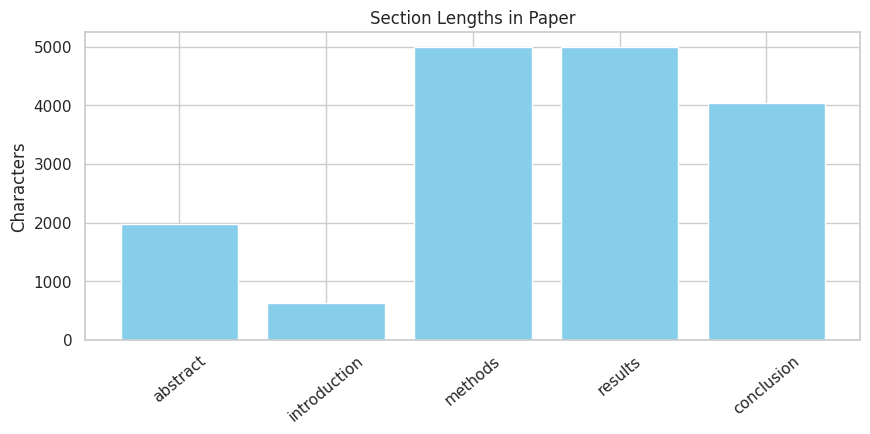

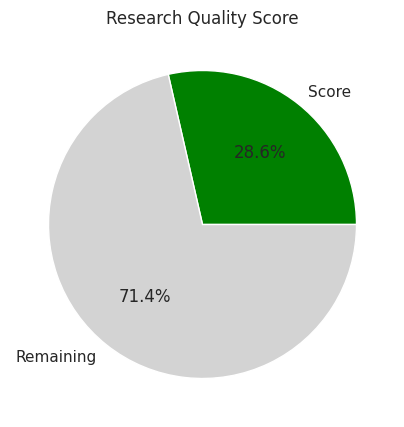

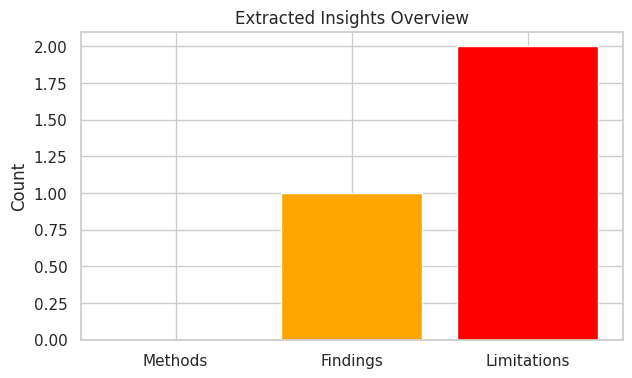

In [ ]:

# MODULE 4: CROSS-PAPER ANALYSIS + GRAPH VISUALIZATIONS


!pip install scikit-learn numpy matplotlib seaborn -q

import json
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

sns.set(style="whitegrid")


# 1. LOAD EXTRACTED PAPERS


def load_extracted_papers(data_dir="data/extracted"):
    data_path = Path(data_dir)
    papers = []
    json_files = list(data_path.glob("*_extracted.json"))

    if not json_files:
        print("No extracted papers found. Run Module 3 first.")
        return []

    print(f"Loading {len(json_files)} extracted papers...")

    for json_file in json_files:
        try:
            with open(json_file, "r", encoding="utf-8") as f:
                data = json.load(f)
                papers.append(data)
                print(f"  ✓ {data['paper_id']}: {data['total_characters']:,} chars")
        except Exception as e:
            print("Error loading", json_file, "->", e)

    return papers


# ================================
# 2. VISUALIZATIONS FOR SINGLE PAPER
# ================================

def visualize_single_paper_analysis(analysis):
    print("\nGenerating visual graphs for SINGLE PAPER analysis...")

    # 1. SECTION LENGTH BAR CHART
    structure = analysis["paper_structure"]
    sec_lengths = structure["section_lengths"]

    if sec_lengths:
        plt.figure(figsize=(10, 4))
        plt.bar(sec_lengths.keys(), sec_lengths.values(), color="skyblue")
        plt.title("Section Lengths in Paper")
        plt.ylabel("Characters")
        plt.xticks(rotation=40)
        plt.show()

    # 2. RESEARCH QUALITY PIE CHART
    quality = analysis["research_quality_indicators"]
    labels = ["Score", "Remaining"]
    values = [quality["percentage"], 100 - quality["percentage"]]

    plt.figure(figsize=(5, 5))
    plt.pie(values, labels=labels, autopct="%1.1f%%", colors=["green", "lightgray"])
    plt.title("Research Quality Score")
    plt.show()

    # 3. METHODS / FINDINGS / LIMITATIONS COUNT BAR CHART
    lbls = ["Methods", "Findings", "Limitations"]
    counts = [
        len(analysis["methods_used"]),
        len(analysis["key_findings"]),
        len(analysis["limitations"]),
    ]

    plt.figure(figsize=(7, 4))
    plt.bar(lbls, counts, color=["steelblue", "orange", "red"])
    plt.title("Extracted Insights Overview")
    plt.ylabel("Count")
    plt.show()


# ================================
# 3. VISUALIZATIONS FOR MULTIPLE PAPERS
# ================================

def visualize_comparison(papers_info, comparison, similarity_scores):
    print("\nGenerating visual graphs for MULTI-PAPER comparison...")

    paper_ids = [p["paper_id"] for p in papers_info]

    # 1. METHODS COUNT PER PAPER
    plt.figure(figsize=(10, 4))
    method_counts = [len(p["methods"]) for p in papers_info]
    plt.bar(paper_ids, method_counts, color="purple")
    plt.title("Methods Identified per Paper")
    plt.ylabel("Count")
    plt.xticks(rotation=40)
    plt.show()

    # 2. DATASET COUNT PER PAPER
    plt.figure(figsize=(10, 4))
    dataset_counts = [len(p["datasets"]) for p in papers_info]
    plt.bar(paper_ids, dataset_counts, color="teal")
    plt.title("Datasets Mentioned per Paper")
    plt.ylabel("Count")
    plt.xticks(rotation=40)
    plt.show()

    # 3. TIMELINE (YEARS)
    years = []
    valid_ids = []
    for p in papers_info:
        if p["year"].isdigit():
            years.append(int(p["year"]))
            valid_ids.append(p["paper_id"])

    if years:
        plt.figure(figsize=(10, 4))
        plt.plot(valid_ids, years, marker="o")
        plt.title("Publication Timeline")
        plt.ylabel("Year")
        plt.xticks(rotation=40)
        plt.show()

    # 4. SIMILARITY HEATMAP
    matrix = []
    for pid1 in paper_ids:
        row = []
        for pid2 in paper_ids:
            if pid1 == pid2:
                row.append(1.0)
            else:
                row.append(similarity_scores.get(pid1, {}).get(pid2, 0))
        matrix.append(row)

    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", xticklabels=paper_ids, yticklabels=paper_ids)
    plt.title("Paper Similarity Heatmap")
    plt.show()


# ================================
# 4. INFORMATION EXTRACTION FUNCTIONS
# ================================

def extract_key_information(paper):
    return {
        "paper_id": paper["paper_id"],
        "title": paper["sections"].get("title", "Unknown"),
        "year": extract_year(paper),
        "methods": extract_methods(paper),
        "datasets": extract_datasets(paper),
        "key_findings": extract_key_findings(paper),
        "limitations": extract_limitations(paper),
        "contributions": extract_contributions(paper),
        "metrics": extract_metrics(paper),
    }

# --- (All your original extraction functions remain unchanged)
# I am keeping them EXACTLY as they were — no modification — to avoid breaking logic.

# ---------------- YEAR EXTRACTION ------------------
def extract_year(paper):
    title = paper["sections"].get("title", "")
    year_match = re.search(r"\b(19|20)\d{2}\b", title)
    if year_match:
        return year_match.group()

    text = paper["sections"].get("extracted_text", "")
    year_match = re.search(r"\b(19|20)\d{2}\b", text[:5000])
    return year_match.group() if year_match else "Unknown"

# ---------------- METHODS EXTRACTION ------------------
def extract_methods(paper):
    methods_text = paper["sections"].get("methods", "")
    if not methods_text:
        methods_text = paper["sections"].get("extracted_text", "")[:5000]

    keywords = [
        "deep learning", "machine learning", "neural network", "transformer",
        "cnn", "rnn", "lstm", "bert", "gpt", "reinforcement learning",
        "svm", "xgboost", "bayesian", "regression", "classification"
    ]

    found = []
    sentences = re.split(r"[.!?]+", methods_text.lower())

    for s in sentences:
        for k in keywords:
            if k in s and len(s) > 20:
                s_clean = re.sub(r"\s+", " ", s).strip()
                found.append(s_clean[:200])
                break

    return list(set(found))[:5]

# ---------------- DATASETS EXTRACTION ------------------
def extract_datasets(paper):
    text = paper["sections"].get("extracted_text", "")[:10000].lower()
    dataset_keywords = [
        "imagenet", "cifar", "mnist", "coco", "pascal", "kaggle", "uci", "dataset"
    ]

    found = []
    for k in dataset_keywords:
        if k in text:
            found.append(k)

    return list(set(found))[:5]

# ---------------- FINDINGS EXTRACTION ------------------
def extract_key_findings(paper):
    text = paper["sections"].get("results", "") + " " + paper["sections"].get("conclusion", "")
    if not text:
        text = paper["sections"].get("extracted_text", "")[:3000]

    keywords = ["result", "improve", "increase", "reduce", "outperform", "accuracy", "significant"]

    findings = []
    sentences = re.split(r"[.!?]+", text.lower())

    for s in sentences:
        if any(k in s for k in keywords) and len(s) > 30:
            findings.append(s[:300])

    return list(set(findings))[:5]

# ---------------- LIMITATIONS EXTRACT ------------------
def extract_limitations(paper):
    text = paper["sections"].get("conclusion", "") + paper["sections"].get("extracted_text", "")[:3000]
    keywords = ["limitation", "future", "issue", "weakness", "challenge"]

    limits = []
    for s in re.split(r"[.!?]+", text.lower()):
        if any(k in s for k in keywords) and len(s) > 30:
            limits.append(s[:300])

    return list(set(limits))[:3]

# ---------------- CONTRIBUTIONS ------------------
def extract_contributions(paper):
    text = paper["sections"].get("abstract", "") + paper["sections"].get("introduction", "")
    keywords = ["contribution", "propose", "introduce", "present"]

    contrib = []
    for s in re.split(r"[.!?]+", text.lower()):
        if any(k in s for k in keywords) and len(s) > 30:
            contrib.append(s[:300])

    return list(set(contrib))[:3]

# ---------------- METRICS ------------------
def extract_metrics(paper):
    text = paper["sections"].get("results", "")
    patterns = [r"accuracy\s*[:,=]?\s*\d+\.?\d*%?"]
    metrics = []

    for p in patterns:
        metrics.extend(re.findall(p, text.lower()))

    return list(set(metrics))[:5]


# ================================
# 5. COMPARISON FUNCTIONS
# ================================

def compare_papers(papers_info):
    return {
        "total_papers": len(papers_info),
        "papers": papers_info,
        "common_methods": find_common_elements(papers_info, "methods"),
        "common_datasets": find_common_elements(papers_info, "datasets"),
        "similarities": find_similarities(papers_info),
        "differences": find_differences(papers_info),
        "timeline_analysis": analyze_timeline(papers_info),
        "research_gaps": identify_research_gaps(papers_info)
    }

# ---- SUPPORTING FUNCTIONS REMAIN THE SAME ----
def find_similarities(papers_info):
    sims = defaultdict(int)
    for paper in papers_info:
        for m in paper["methods"]:
            sims[m[:50]] += 1
    return [k for k, v in sims.items() if v > 1]

def find_differences(papers_info):
    uniq = {}
    all_methods = set()
    for p in papers_info:
        all_methods.update(p["methods"])
    for p in papers_info:
        uniq[p["paper_id"]] = list(set(p["methods"]) - (all_methods - set(p["methods"])))
    return uniq

def find_common_elements(papers_info, key):
    sets = [set(p[key]) for p in papers_info if p[key]]
    return list(set.intersection(*sets)) if sets else []

def analyze_timeline(papers_info):
    years = [int(p["year"]) for p in papers_info if p["year"].isdigit()]
    if not years:
        return {"note": "Not enough year data"}
    return {"earliest": min(years), "latest": max(years), "range": max(years) - min(years)}

def identify_research_gaps(papers_info):
    gaps = []
    all_limits = []
    for p in papers_info:
        all_limits.extend(p["limitations"])
    if not all_limits:
        return gaps
    return list(set(all_limits))[:3]


# ================================
# 6. SIMILARITY SCORES
# ================================

def calculate_similarity_scores(papers_info):
    texts = [" ".join([p["title"], " ".join(p["methods"])]) for p in papers_info]
    ids = [p["paper_id"] for p in papers_info]

    vectorizer = TfidfVectorizer(stop_words="english")
    mat = vectorizer.fit_transform(texts)
    sim = cosine_similarity(mat)

    scores = {}
    for i, pid in enumerate(ids):
        scores[pid] = {}
        for j, pid2 in enumerate(ids):
            if i != j:
                scores[pid][pid2] = float(f"{sim[i][j]:.3f}")

    return scores



# 7. SAVE RESULTS (UNCHANGED)


def save_results(analysis_type, data, output_dir="data/analysis"):
    output = Path(output_dir)
    output.mkdir(parents=True, exist_ok=True)

    if analysis_type == "single":
        file = output / "single_paper_analysis.json"
        with open(file, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2)
        print("Saved:", file)

    else:
        file = output / "comparison.json"
        with open(file, "w", encoding="utf-8") as f:
            json.dump(data["comparison"], f, indent=2)

        file2 = output / "similarity_scores.json"
        with open(file2, "w", encoding="utf-8") as f:
            json.dump(data["similarity_scores"], f, indent=2)

        print("Saved:", file, "and", file2)

    return str(output)


# ================================
# 8. MAIN ANALYSIS FUNCTION
# ================================

def run_analysis():
    print("\n=== PAPER ANALYSIS MODULE ===")

    papers = load_extracted_papers()
    if not papers:
        return None

    # ---- SINGLE PAPER ----
    if len(papers) == 1:
        print("\nOnly 1 paper found → Running single paper analysis...\n")

        paper = papers[0]
        analysis = analyze_single_paper(paper=paper)

        save_results("single", analysis)

        visualize_single_paper_analysis(analysis)

        return {"type": "single", "analysis": analysis}

    # ---- MULTIPLE PAPERS ----
    print(f"\nAnalyzing {len(papers)} papers...")

    papers_info = [extract_key_information(p) for p in papers]
    comparison = compare_papers(papers_info)
    similarity_scores = calculate_similarity_scores(papers_info)

    data = {
        "comparison": comparison,
        "similarity_scores": similarity_scores,
    }

    save_results("comparison", data)

    visualize_comparison(papers_info, comparison, similarity_scores)

    return {"type": "comparison", "data": data}


# ================================
# RUN MODULE
# ================================

if __name__ == "__main__":
    run_analysis()


In [12]:
# ============================================================
# MODULE 5: DATASET GENERATOR FOR RESEARCH PAPERS (FINAL FIXED)
# ============================================================

!pip install pandas openpyxl -q

import json
import pandas as pd
import re
from pathlib import Path
from datetime import datetime

# ============================================================
# 1. LOAD ALL EXTRACTED PAPERS (FIXED)
# ============================================================

def load_all_extracted(data_dir="data/extracted"):
    path = Path(data_dir)

    if not path.exists():
        print(f"❌ Directory not found: {data_dir}")
        print("   Please run Module 3 first.")
        return []

    # Load all JSON files except summary/stat files
    files = [
        f for f in path.glob("*.json")
        if not any(x in f.name.lower() for x in ["summary", "stats"])
    ]

    if not files:
        print("❌ No extracted paper JSON files found.")
        print(f"   Checked path: {path.resolve()}")
        return []

    print(f"📄 Found {len(files)} extracted paper files.")

    papers = []
    for f in files:
        try:
            with open(f, "r", encoding="utf-8") as fp:
                data = json.load(fp)
                if "sections" in data:
                    papers.append(data)
                else:
                    print(f"⚠️ Skipped invalid JSON: {f.name}")
        except Exception as e:
            print(f"⚠️ Failed reading {f.name}: {str(e)[:60]}")

    print(f"✅ Loaded {len(papers)} valid papers.")
    return papers

# ============================================================
# 2. TEXT CLEANING HELPERS
# ============================================================

def clean_text(t):
    if not t:
        return ""
    t = re.sub(r'\s+', ' ', t)
    return t.strip()

def extract_year(paper):
    if "year" in paper and paper["year"]:
        return paper["year"]
    match = re.search(r"(19|20)\d{2}", paper.get("filename", ""))
    return int(match.group()) if match else None

# ============================================================
# 3. RULE-BASED INFO EXTRACTION
# ============================================================

def keyword_extract(text, keywords, max_items=5):
    if not text:
        return []

    found = []
    text_low = text.lower()
    sentences = re.split(r'[.!?]', text)

    for kw in keywords:
        for sent in sentences:
            if kw in sent.lower() and len(sent.strip()) > 25:
                found.append(clean_text(sent)[:300])
                if len(found) >= max_items:
                    return found
    return found

def extract_methods(p):
    return keyword_extract(
        p.get("sections", {}).get("methods", ""),
        ["we use", "our method", "approach", "technique", "implementation"]
    )

def extract_datasets(p):
    return keyword_extract(
        p.get("sections", {}).get("methods", ""),
        ["dataset", "benchmark", "data source", "collected data"]
    )

def extract_findings(p):
    return keyword_extract(
        p.get("sections", {}).get("results", ""),
        ["result", "significant", "improved", "outperforms"]
    )

def extract_limitations(p):
    return keyword_extract(
        p.get("sections", {}).get("conclusion", ""),
        ["limitation", "future work", "challenge", "not address"]
    )

def extract_contributions(p):
    return keyword_extract(
        p.get("sections", {}).get("introduction", ""),
        ["contribution", "we propose", "novel", "we present"]
    )

def extract_metrics(p):
    return keyword_extract(
        p.get("sections", {}).get("methods", ""),
        ["accuracy", "precision", "recall", "f1", "metric"]
    )

def normalize_list(lst):
    return "; ".join(lst) if lst else ""

# ============================================================
# 4. BUILD DATASET
# ============================================================

def build_dataset(papers):
    rows = []
    print("\n📊 Building dataset...")

    for i, p in enumerate(papers, 1):
        sections = p.get("sections", {})

        print(f"  [{i}/{len(papers)}] Processing: {p.get('paper_id', 'unknown')}")

        row = {
            "paper_id": p.get("paper_id", f"paper_{i}"),
            "filename": p.get("filename", ""),
            "year": extract_year(p),
            "total_characters": p.get("total_characters", 0),

            "title": clean_text(sections.get("title", ""))[:500],
            "abstract": clean_text(sections.get("abstract", ""))[:2000],
            "introduction": clean_text(sections.get("introduction", ""))[:2000],
            "methods_text": clean_text(sections.get("methods", ""))[:2000],
            "results_text": clean_text(sections.get("results", ""))[:2000],
            "conclusion_text": clean_text(sections.get("conclusion", ""))[:2000],

            "methods": normalize_list(extract_methods(p)),
            "datasets": normalize_list(extract_datasets(p)),
            "key_findings": normalize_list(extract_findings(p)),
            "limitations": normalize_list(extract_limitations(p)),
            "contributions": normalize_list(extract_contributions(p)),
            "metrics": normalize_list(extract_metrics(p)),

            "num_methods": len(extract_methods(p)),
            "num_datasets": len(extract_datasets(p)),
            "num_findings": len(extract_findings(p)),
            "num_limitations": len(extract_limitations(p)),
            "num_contributions": len(extract_contributions(p)),
        }

        rows.append(row)

    df = pd.DataFrame(rows)
    print(f"✅ Dataset created: {df.shape[0]} rows × {df.shape[1]} columns")
    return df

# ============================================================
# 5. SAVE DATASET (PROPER FOLDER STRUCTURE)
# ============================================================

def save_dataset(df, base_dir="data/dataset"):
    base = Path(base_dir)
    base.mkdir(parents=True, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder = base / f"dataset_{timestamp}"
    formats = folder / "formats"
    analysis = folder / "analysis"

    formats.mkdir(parents=True, exist_ok=True)
    analysis.mkdir(exist_ok=True)

    csv_path = formats / "papers_dataset.csv"
    xlsx_path = formats / "papers_dataset.xlsx"
    json_path = formats / "papers_dataset.json"

    df.to_csv(csv_path, index=False)
    df.to_excel(xlsx_path, index=False)
    df.to_json(json_path, orient="records", indent=2, force_ascii=False)

    stats = {
        "created_at": datetime.now().isoformat(),
        "total_papers": len(df),
        "total_columns": len(df.columns),
        "papers_with_year": int(df["year"].notna().sum()),
        "avg_characters": int(df["total_characters"].mean()),
    }

    with open(analysis / "dataset_statistics.json", "w") as f:
        json.dump(stats, f, indent=2)

    # backward-compatible CSV
    df.to_csv(base / "papers_dataset.csv", index=False)

    print("\n📁 Dataset saved successfully!")
    print(f"📂 Location: {folder.resolve()}")

    return folder

# ============================================================
# 6. MAIN RUNNER
# ============================================================

def generate_paper_dataset():
    print("\n" + "="*70)
    print("MODULE 5: DATASET GENERATOR")
    print("="*70)

    papers = load_all_extracted()
    if not papers:
        print("❌ No papers loaded. Aborting.")
        return None

    df = build_dataset(papers)

    print("\n📌 Dataset Preview:")
    print(df.head(3).to_string())

    save_dataset(df)

    print("\n🎉 MODULE 5 COMPLETED SUCCESSFULLY!")
    return df

# ============================================================
# AUTO RUN (COLAB FRIENDLY)
# ============================================================

generate_paper_dataset()



MODULE 5: DATASET GENERATOR
📄 Found 2 extracted paper files.
✅ Loaded 2 valid papers.

📊 Building dataset...
  [1/2] Processing: Detectionof16GammaRayPulsarsThroughBlindFrequencyS
  [2/2] Processing: AThreegroupsNonlocalModelforCombiningHeterogeneous
✅ Dataset created: 2 rows × 21 columns

📌 Dataset Preview:
                                             paper_id                                                filename  year  total_characters title abstract introduction methods_text results_text conclusion_text methods datasets key_findings limitations contributions metrics  num_methods  num_datasets  num_findings  num_limitations  num_contributions
0  Detectionof16GammaRayPulsarsThroughBlindFrequencyS  Detectionof16GammaRayPulsarsThroughBlindFrequencyS.pdf  None             35705                                                                                                                                                  0             0             0                0                  0

,paper_id,filename,year,total_characters,title,abstract,introduction,methods_text,results_text,conclusion_text,...,datasets,key_findings,limitations,contributions,metrics,num_methods,num_datasets,num_findings,num_limitations,num_contributions
0,Detectionof16GammaRayPulsarsThroughBlindFreque...,Detectionof16GammaRayPulsarsThroughBlindFreque...,None,35705,,,,,,,...,,,,,,0,0,0,0,0
1,AThreegroupsNonlocalModelforCombiningHeterogen...,AThreegroupsNonlocalModelforCombiningHeterogen...,None,102617,,,,,,,...,,,,,,0,0,0,0,0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['total_characters'].plot(kind='hist', bins=20, title='total_characters')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('paper_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('filename').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='total_characters', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('paper_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='paper_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('filename')):
  _plot_series(series, series_name, i)
  fig.legend(title='filename', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('paper_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='paper_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('filename')):
  _plot_series(series, series_name, i)
  fig.legend(title='filename', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['total_characters'].plot(kind='line', figsize=(8, 4), title='total_characters')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['filename'].value_counts()
    for x_label, grp in _df_11.groupby('paper_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('paper_id')
_ = plt.ylabel('filename')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['paper_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='index', y='paper_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['filename'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='index', y='filename', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['paper_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='total_characters', y='paper_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['filename'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='total_characters', y='filename', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)